# Synthetic Data Generation Using RAGAS - RAG Evaluation with LangSmith

In the following notebook we'll explore a use-case for RAGAS' synthetic testset generation workflow!



- 🤝 BREAKOUT ROOM #1
  1. Use RAGAS to Generate Synthetic Data

- 🤝 BREAKOUT ROOM #2
  1. Load them into a LangSmith Dataset
  2. Evaluate our RAG chain against the synthetic test data
  3. Make changes to our pipeline
  4. Evaluate the modified pipeline

SDG is a critical piece of the puzzle, especially for early iteration! Without it, it would not be nearly as easy to get high quality early signal for our application's performance.

Let's dive in!

# 🤝 BREAKOUT ROOM #1

## Task 1: Dependencies and API Keys

We'll need to install a number of API keys and dependencies, since we'll be leveraging a number of great technologies for this pipeline!

1. OpenAI's endpoints to handle the Synthetic Data Generation
2. OpenAI's Endpoints for our RAG pipeline and LangSmith evaluation
3. QDrant as our vectorstore
4. LangSmith for our evaluation coordinator!

Let's install and provide all the required information below!

## Dependencies and API Keys:

> NOTE: DO NOT RUN THESE CELLS IF YOU ARE RUNNING THIS NOTEBOOK LOCALLY

In [ ]:
#!pip install -qU ragas==0.2.10

In [ ]:
#!pip install -qU langchain-community==0.3.14 langchain-openai==0.2.14 unstructured==0.16.12 langgraph==0.2.61 langchain-qdrant==0.2.0

In [1]:
import os
import getpass

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_API_KEY"] = getpass.getpass("LangChain API Key:")

We'll also want to set a project name to make things easier for ourselves.

In [2]:
from uuid import uuid4

os.environ["LANGCHAIN_PROJECT"] = f"AIM - SDG - {uuid4().hex[0:8]}"

OpenAI's API Key!

In [3]:
os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API Key:")

## Generating Synthetic Test Data

We wil be using Ragas to build out a set of synthetic test questions, references, and reference contexts. This is useful because it will allow us to find out how our system is performing.

> NOTE: Ragas is best suited for finding *directional* changes in your LLM-based systems. The absolute scores aren't comparable in a vacuum.

### Data Preparation

We'll prepare our data - and download our webpages which we'll be using for our data today.

These webpages are from [Simon Willison's](https://simonwillison.net/) yearly "AI learnings".

- [2023 Blog](https://simonwillison.net/2023/Dec/31/ai-in-2023/)
- [2024 Blog](https://simonwillison.net/2024/Dec/31/llms-in-2024/)

Let's start by collecting our data into a useful pile!

In [4]:
#!mkdir data

In [ ]:
#!curl https://simonwillison.net/2023/Dec/31/ai-in-2023/ -o data/2023_llms.html

In [ ]:
#!curl https://simonwillison.net/2024/Dec/31/llms-in-2024/ -o data/2024_llms.html

Next, let's load our data into a familiar LangChain format using the `DirectoryLoader`.

In [4]:
from langchain_community.document_loaders import DirectoryLoader

path = "data/"
loader = DirectoryLoader(path, glob="*.html")
docs = loader.load()

[nltk_data] Downloading package punkt to /home/lewis/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/lewis/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


### Knowledge Graph Based Synthetic Generation

Ragas uses a knowledge graph based approach to create data. This is extremely useful as it allows us to create complex queries rather simply. The additional testset complexity allows us to evaluate larger problems more effectively, as systems tend to be very strong on simple evaluation tasks.

Let's start by defining our `generator_llm` (which will generate our questions, summaries, and more), and our `generator_embeddings` which will be useful in building our graph.

### Unrolled SDG

In [7]:
from ragas.llms import LangchainLLMWrapper
from ragas.embeddings import LangchainEmbeddingsWrapper
from langchain_openai import ChatOpenAI
from langchain_openai import OpenAIEmbeddings
generator_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4o"))
generator_embeddings = LangchainEmbeddingsWrapper(OpenAIEmbeddings())

Next, we're going to instantiate our Knowledge Graph.

This graph will contain N number of nodes that have M number of relationships. These nodes and relationships (AKA "edges") will define our knowledge graph and be used later to construct relevant questions and responses.

In [8]:
from ragas.testset.graph import KnowledgeGraph

kg = KnowledgeGraph()
kg

KnowledgeGraph(nodes: 0, relationships: 0)

The first step we're going to take is to simply insert each of our full documents into the graph. This will provide a base that we can apply transformations to.

In [10]:
from ragas.testset.graph import Node, NodeType

for doc in docs:
    kg.nodes.append(
        Node(
            type=NodeType.DOCUMENT,
            properties={"page_content": doc.page_content, "document_metadata": doc.metadata}
        )
    )
kg

KnowledgeGraph(nodes: 2, relationships: 0)

Now, we'll apply the *default* transformations to our knowledge graph. This will take the nodes currently on the graph and transform them based on a set of [default transformations](https://docs.ragas.io/en/latest/references/transforms/#ragas.testset.transforms.default_transforms).

These default transformations are dependent on the corpus length, in our case:

- Producing Summaries -> produces summaries of the documents
- Extracting Headlines -> finding the overall headline for the document
- Theme Extractor -> extracts broad themes about the documents

It then uses cosine-similarity and heuristics between the embeddings of the above transformations to construct relationships between the nodes.

In [11]:
from ragas.testset.transforms import default_transforms, apply_transforms

transformer_llm = generator_llm
embedding_model = generator_embeddings

default_transforms = default_transforms(documents=docs, llm=transformer_llm, embedding_model=embedding_model)
apply_transforms(kg, default_transforms)
kg

Applying HeadlinesExtractor:   0%|          | 0/2 [00:00<?, ?it/s]

Applying HeadlineSplitter:   0%|          | 0/2 [00:00<?, ?it/s]

Applying SummaryExtractor:   0%|          | 0/2 [00:00<?, ?it/s]

Applying CustomNodeFilter:   0%|          | 0/12 [00:00<?, ?it/s]

Applying [EmbeddingExtractor, ThemesExtractor, NERExtractor]:   0%|          | 0/26 [00:00<?, ?it/s]

Applying [CosineSimilarityBuilder, OverlapScoreBuilder]:   0%|          | 0/2 [00:00<?, ?it/s]

KnowledgeGraph(nodes: 14, relationships: 70)

We can save and load our knowledge graphs as follows.

In [12]:
kg.save("ai_across_years_kg.json")
ai_across_years_kg = KnowledgeGraph.load("ai_across_years_kg.json")
ai_across_years_kg

KnowledgeGraph(nodes: 14, relationships: 70)

Using our knowledge graph, we can construct a "test set generator" - which will allow us to create queries.

In [13]:
from ragas.testset import TestsetGenerator

generator = TestsetGenerator(llm=generator_llm, embedding_model=embedding_model, knowledge_graph=ai_across_years_kg)

However, we'd like to be able to define the kinds of queries we're generating - which is made simple by Ragas having pre-created a number of different "QuerySynthesizer"s.

Each of these Synthetsizers is going to tackle a separate kind of query which will be generated from a scenario and a persona.

In essence, Ragas will use an LLM to generate a persona of someone who would interact with the data - and then use a scenario to construct a question from that data and persona.

In [14]:
from ragas.testset.synthesizers import default_query_distribution, SingleHopSpecificQuerySynthesizer, MultiHopAbstractQuerySynthesizer, MultiHopSpecificQuerySynthesizer

query_distribution = [
        (SingleHopSpecificQuerySynthesizer(llm=generator_llm), 0.5),
        (MultiHopAbstractQuerySynthesizer(llm=generator_llm), 0.25),
        (MultiHopSpecificQuerySynthesizer(llm=generator_llm), 0.25),
]

#### ❓ Question #1:

What are the three types of query synthesizers doing? Describe each one in simple terms.


#### ✅ ANSWER:
> - **SingleHopSpecificQuerySynthesizer:** Creates queries focused on a single, concrete fact or relationship.
> - **MultiHopAbstractQuerySynthesizer:** Generates broader, multi-step questions that connect multiple pieces of data in a more generalized way.
> - **MultiHopSpecificQuerySynthesizer:** Produces multi-step queries that combine concrete details across different parts of the knowledge base.

Finally, we can use our `TestSetGenerator` to generate our testset!

In [15]:
testset = generator.generate(testset_size=10, query_distribution=query_distribution)
testset.to_pandas()

Generating personas:   0%|          | 0/2 [00:00<?, ?it/s]

Generating Scenarios:   0%|          | 0/3 [00:00<?, ?it/s]

Generating Samples:   0%|          | 0/11 [00:00<?, ?it/s]

,user_input,reference_contexts,reference,synthesizer_name
0,Wht has Microsoft Research contributed to the ...,[Code may be the best application The ethics o...,Microsoft Research has contributed to the deve...,single_hop_specifc_query_synthesizer
1,Wht is JavaScript?,[Based Development As a computer scientist and...,The context does not provide information about...,single_hop_specifc_query_synthesizer
2,What happened with AI and Large Language Model...,[Simon Willison’s Weblog Subscribe Stuff we fi...,"By 31st December 2023, it was recognized as a ...",single_hop_specifc_query_synthesizer
3,What are the implications of the 'Stable Diffu...,[easy to follow. The rest of the document incl...,The 'Stable Diffusion moment' for large langua...,single_hop_specifc_query_synthesizer
4,What notable advancements did Google introduce...,[Prompt driven app generation is a commodity a...,"Google's Gemini 1.5 Pro, released in February ...",single_hop_specifc_query_synthesizer
5,How have advancements in large language models...,[<1-hop>\n\nPrompt driven app generation is a ...,Advancements in large language models (LLMs) h...,multi_hop_abstract_query_synthesizer
6,How do the advancements in large language mode...,[<1-hop>\n\nPrompt driven app generation is a ...,"The advancements in large language models, par...",multi_hop_abstract_query_synthesizer
7,How do advancements in large language models a...,[<1-hop>\n\nPrompt driven app generation is a ...,Advancements in large language models (LLMs) h...,multi_hop_abstract_query_synthesizer
8,What advancements in GPT-4 and other large lan...,[<1-hop>\n\nSimon Willison’s Weblog Subscribe ...,"In 2023, GPT-4 and other large language models...",multi_hop_specific_query_synthesizer
9,What are the challenges and potential solution...,[<1-hop>\n\nBased Development As a computer sc...,The challenges in improving the reliability an...,multi_hop_specific_query_synthesizer


### Abstracted SDG

The above method is the full process - but we can shortcut that using the provided abstractions!

This will generate our knowledge graph under the hood, and will - from there - generate our personas and scenarios to construct our queries.



In [16]:
from ragas.testset import TestsetGenerator

generator = TestsetGenerator(llm=generator_llm, embedding_model=generator_embeddings)
dataset = generator.generate_with_langchain_docs(docs, testset_size=10)

Applying HeadlinesExtractor:   0%|          | 0/2 [00:00<?, ?it/s]

Applying HeadlineSplitter:   0%|          | 0/2 [00:00<?, ?it/s]

Applying SummaryExtractor:   0%|          | 0/2 [00:00<?, ?it/s]

Applying CustomNodeFilter:   0%|          | 0/12 [00:00<?, ?it/s]

Applying [EmbeddingExtractor, ThemesExtractor, NERExtractor]:   0%|          | 0/26 [00:00<?, ?it/s]

Applying [CosineSimilarityBuilder, OverlapScoreBuilder]:   0%|          | 0/2 [00:00<?, ?it/s]

Generating personas:   0%|          | 0/2 [00:00<?, ?it/s]

Generating Scenarios:   0%|          | 0/3 [00:00<?, ?it/s]

Generating Samples:   0%|          | 0/12 [00:00<?, ?it/s]

In [17]:
dataset.to_pandas()

,user_input,reference_contexts,reference,synthesizer_name
0,What we learn about LLMs in 2024?,[Code may be the best application The ethics o...,"In 2024, we learned that Large Language Models...",single_hop_specifc_query_synthesizer
1,Whatt are the challenges of using LLMs in Span...,[Based Development As a computer scientist and...,The challenges of using LLMs in Spanish langua...,single_hop_specifc_query_synthesizer
2,What significant development in AI occurred in...,[Simon Willison’s Weblog Subscribe Stuff we fi...,2023 was the breakthrough year for Large Langu...,single_hop_specifc_query_synthesizer
3,How has OpenAI been discussed in the context o...,[easy to follow. The rest of the document incl...,OpenAI has been a significant topic of discuss...,single_hop_specifc_query_synthesizer
4,How do the ethics of AI and the gullibility of...,[<1-hop>\n\nCode may be the best application T...,The ethics of AI and the gullibility of langua...,multi_hop_abstract_query_synthesizer
5,How do the challenges of understanding and con...,[<1-hop>\n\nCode may be the best application T...,The challenges of understanding and controllin...,multi_hop_abstract_query_synthesizer
6,How do the challenges of understanding and con...,[<1-hop>\n\nCode may be the best application T...,The challenges of understanding and controllin...,multi_hop_abstract_query_synthesizer
7,How does the gullibility of language models im...,[<1-hop>\n\nCode may be the best application T...,The gullibility of language models significant...,multi_hop_abstract_query_synthesizer
8,What were the major developments and ethical c...,[<1-hop>\n\nSimon Willison’s Weblog Subscribe ...,"In 2023, Large Language Models (LLMs) marked a...",multi_hop_specific_query_synthesizer
9,How has the development of Claude 3 and other ...,[<1-hop>\n\ngets you OpenAI’s most expensive m...,The development of Claude 3 and other multi-mo...,multi_hop_specific_query_synthesizer


We'll need to provide our LangSmith API key, and set tracing to "true".

# 🤝 BREAKOUT ROOM #2

## Task 4: LangSmith Dataset

Now we can move on to creating a dataset for LangSmith!

First, we'll need to create a dataset on LangSmith using the `Client`!

We'll name our Dataset to make it easy to work with later.

In [18]:
from langsmith import Client

client = Client()

dataset_name = "State of AI Across the Years!"

langsmith_dataset = client.create_dataset(
    dataset_name=dataset_name,
    description="State of AI Across the Years!"
)

We'll iterate through the RAGAS created dataframe - and add each example to our created dataset!

> NOTE: We need to conform the outputs to the expected format - which in this case is: `question` and `answer`.

In [19]:
for data_row in dataset.to_pandas().iterrows():
  client.create_example(
      inputs={
          "question": data_row[1]["user_input"]
      },
      outputs={
          "answer": data_row[1]["reference"]
      },
      metadata={
          "context": data_row[1]["reference_contexts"]
      },
      dataset_id=langsmith_dataset.id
  )

## Basic RAG Chain

Time for some RAG!


In [20]:
rag_documents = docs

To keep things simple, we'll just use LangChain's recursive character text splitter!


In [21]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 500,
    chunk_overlap = 50
)

rag_documents = text_splitter.split_documents(rag_documents)

We'll create our vectorstore using OpenAI's [`text-embedding-3-small`](https://platform.openai.com/docs/guides/embeddings/embedding-models) embedding model.

In [22]:
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

As usual, we will power our RAG application with Qdrant!

In [23]:
from langchain_community.vectorstores import Qdrant

vectorstore = Qdrant.from_documents(
    documents=rag_documents,
    embedding=embeddings,
    location=":memory:",
    collection_name="State of AI"
)

In [24]:
retriever = vectorstore.as_retriever(search_kwargs={"k": 10})

To get the "A" in RAG, we'll provide a prompt.

In [25]:
from langchain.prompts import ChatPromptTemplate

RAG_PROMPT = """\
Given a provided context and question, you must answer the question based only on context.

If you cannot answer the question based on the context - you must say "I don't know".

Context: {context}
Question: {question}
"""

rag_prompt = ChatPromptTemplate.from_template(RAG_PROMPT)

For our LLM, we will be using TogetherAI's endpoints as well!

We're going to be using Meta Llama 3.1 70B Instruct Turbo - a powerful model which should get us powerful results!

In [26]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini")

Finally, we can set-up our RAG LCEL chain!

In [27]:
from operator import itemgetter
from langchain_core.runnables import RunnablePassthrough, RunnableParallel
from langchain.schema import StrOutputParser

rag_chain = (
    {"context": itemgetter("question") | retriever, "question": itemgetter("question")}
    | rag_prompt | llm | StrOutputParser()
)

In [28]:
rag_chain.invoke({"question" : "What are Agents?"})

'Agents are described as AI systems that can act on behalf of users. However, the term "agents" is considered vague and lacks a single, clear definition. There are different interpretations: some view agents as entities that perform tasks for you (like a travel agent), while others think of them as LLMs with access to tools to solve problems. The concept is still evolving, and while there is excitement around AI agents, concrete examples of them in production are scarce. Challenges such as gullibility in AI systems also cast doubt on their utility.'

## LangSmith Evaluation Set-up

We'll use OpenAI's GPT-4o as our evaluation LLM for our base Evaluators.

In [29]:
eval_llm = ChatOpenAI(model="gpt-4o")

We'll be using a number of evaluators - from LangSmith provided evaluators, to a few custom evaluators!

In [30]:
from langsmith.evaluation import LangChainStringEvaluator, evaluate

qa_evaluator = LangChainStringEvaluator("qa", config={"llm" : eval_llm})

labeled_helpfulness_evaluator = LangChainStringEvaluator(
    "labeled_criteria",
    config={
        "criteria": {
            "helpfulness": (
                "Is this submission helpful to the user,"
                " taking into account the correct reference answer?"
            )
        },
        "llm" : eval_llm
    },
    prepare_data=lambda run, example: {
        "prediction": run.outputs["output"],
        "reference": example.outputs["answer"],
        "input": example.inputs["question"],
    }
)

dope_or_nope_evaluator = LangChainStringEvaluator(
    "criteria",
    config={
        "criteria": {
            "dopeness": "Is this submission dope, lit, or cool?",
        },
        "llm" : eval_llm
    }
)

#### 🏗️ Activity #2:

Highlight what each evaluator is evaluating.

- `qa_evaluator`: 
- `labeled_helpfulness_evaluator`: 
- `dope_or_nope_evaluator`: 

#### ✅ ANSWER:
- `qa_evaluator`: Uses default QA validation.  Evaluates the correctness of the generated answers by comparing them to the reference answers.
- `labeled_helpfulness_evaluator`: Adds reference-aware helpfulness assessment.  Assesses how helpful the submission is to the user, considering the correct reference answer.
- `dope_or_nope_evaluator`: Introduces subjective style evaluation. Judges the "coolness" or appeal of the submission based on its perceived dopeness.

## LangSmith Evaluation

In [31]:
evaluate(
    rag_chain.invoke,
    data=dataset_name,
    evaluators=[
        qa_evaluator,
        labeled_helpfulness_evaluator,
        dope_or_nope_evaluator
    ],
    metadata={"revision_id": "default_chain_init"},
)

View the evaluation results for experiment: 'shiny-hill-52' at:
https://smith.langchain.com/o/df6cd833-569f-46ec-9ae9-90000a6e38c6/datasets/56dc8d24-5430-4cf9-9924-0c18ae0e21ec/compare?selectedSessions=0deafbad-6c68-47a1-b9ec-22e11956c3f9




0it [00:00, ?it/s]

,inputs.question,outputs.output,error,reference.answer,feedback.correctness,feedback.helpfulness,feedback.dopeness,execution_time,example_id,id
0,How does the concept of 'Vibes Based Developme...,The concept of 'Vibes Based Development' sugge...,None,The concept of 'Vibes Based Development' relat...,1,1,0,4.393540,c5777446-815a-4a57-b122-b1548a60c61b,c8d9a87b-4823-4aff-9b25-368f3725fa16
1,How has the development of Meta's Llama 3.2 mo...,The development of Meta's Llama 3.2 models has...,None,Meta's Llama 3.2 models have significantly imp...,1,1,1,3.730530,149428fb-d2f8-4134-b503-8536dd7fd4e2,4f049c4e-6517-4a3e-957a-7ea8431b6459
2,How has the development of Claude 3 and other ...,The development of Claude 3 and other multi-mo...,None,The development of Claude 3 and other multi-mo...,1,1,0,3.764666,870d62c3-464b-4933-b2eb-cbdf0d7ca8cf,91a7fb36-6f85-406b-8cd5-16fa25ec7181
3,What were the major developments and ethical c...,"In 2023, major developments in AI, particularl...",None,"In 2023, Large Language Models (LLMs) marked a...",1,0,0,4.024654,a8258c4d-d197-4b96-9cf2-f35669710aff,073595f3-2523-46f8-bd94-d692e1f05dbd
4,How does the gullibility of language models im...,The gullibility of language models impacts the...,None,The gullibility of language models significant...,1,1,0,4.621480,875dca6c-ff28-4ed4-932b-515297e3aec5,b7a10d8b-2ce4-4e77-a58b-4d6344165765
5,How do the challenges of understanding and con...,I don't know.,None,The challenges of understanding and controllin...,0,0,0,1.419223,491a9068-fc84-4fb9-a191-7fc6515b2f89,71350385-4586-4dbb-83cd-9af4bf1f2074
6,How do the challenges of understanding and con...,The challenges of understanding and controllin...,None,The challenges of understanding and controllin...,1,1,0,4.273992,8e758690-7023-413e-a159-177a4b2fb78e,558a3a95-f456-44f8-b0a0-c49af475bd51
7,How do the ethics of AI and the gullibility of...,The ethics of AI and the gullibility of langua...,None,The ethics of AI and the gullibility of langua...,1,1,0,3.989137,2c0aa780-47c5-4831-a4f7-b262e97b6ff2,c05cda62-ac85-4b0c-b604-feee404a481d
8,How has OpenAI been discussed in the context o...,The context discusses OpenAI in relation to th...,None,OpenAI has been a significant topic of discuss...,1,0,0,3.571708,e44c627a-7e33-47b7-b465-7c895ab9d583,31e0f811-5d21-456c-86ba-c5b9421dcdd8
9,What significant development in AI occurred in...,2023 was the breakthrough year for Large Langu...,None,2023 was the breakthrough year for Large Langu...,1,1,1,1.804213,2cb4e7ca-cf81-49db-bd48-5cb5d75d5f90,bbe0949a-1cac-4707-8472-6441e40c8704


## Dope-ifying Our Application

We'll be making a few changes to our RAG chain to increase its performance on our SDG evaluation test dataset!

- Include a "dope" prompt augmentation
- Use larger chunks
- Improve the retriever model to: `text-embedding-3-large`

Let's see how this changes our evaluation!

In [32]:
DOPE_RAG_PROMPT = """\
Given a provided context and question, you must answer the question based only on context.

If you cannot answer the question based on the context - you must say "I don't know".

You must answer the questions in a dope way, be cool!

Context: {context}
Question: {question}
"""

dope_rag_prompt = ChatPromptTemplate.from_template(DOPE_RAG_PROMPT)

In [33]:
rag_documents = docs

In [34]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 1000,
    chunk_overlap = 50
)

rag_documents = text_splitter.split_documents(rag_documents)

#### ❓Question #2:

Why would modifying our chunk size modify the performance of our application?

#### ✅ ANSWER:
1. Context Preservation  
**Larger chunks (1000 chars):**  
✅ Better at preserving complete context/relationships  
✅ Better for complex, multi-faceted questions  
❌ Higher risk of irrelevant information in retrieved chunks  

2. Retrieval Precision  
**Smaller chunks (500 chars):**  
✅ More focused semantic matches  
✅ Better for factoid/specific questions  
❌ May miss broader context needed for synthesis  

Performance Depends On:  
🔍 **Question type**: Factoid vs analytical  
📄 **Document structure**: Dense vs narrative  
🤖 **Embedding model**: How well it handles longer texts  

*There's no universal "better" - we need to test both configurations with our specific data and queries!* 🔍

In [35]:
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

#### ❓Question #3:

Why would modifying our embedding model modify the performance of our application?

#### ✅ ANSWER:
1. **Semantic Representation Quality**  
- `text-embedding-3-large` produces more nuanced vector representations due to:
  - Larger model size: Better capture of subtle semantic relationships
  - Higher dimensionality: 3072 vs 1536 dimensions in small version
  - Improved training: Better handling of complex linguistic patterns

2. **Retrieval Accuracy**  
- Better embeddings lead to:
  - Reduced irrelevant context retrieval
  - Improved identification of semantically similar concepts
  - Better handling of uncommon/long-tail terminology

3. **Chunk Size Interaction**
- `text-embedding-3-large` + `chunk_size=1000`:
  - Better preserves meaning in larger text segments
  - Maintains contextual relationships in bigger chunks
- `text-embedding-3-small` + `chunk_size=500`:
  - Works better with focused, smaller chunks
  - Affects context quantity reaching the LLM

4. **Query-Document Alignment**  
- Embedding model affects:
  - 3-large: Better understands implicit concept relationships
  - 3-small: Might miss subtle textual connections
  - Directly impacts answer quality through context relevance

5. **Dimensionality Effects**  
- 3-large (3072D): 
  - Captures fine-grained features
  - Better distinguishes similar concepts
- 3-small (1536D): 
  - May collapse related concepts
  - Affects recall/precision balance

**Combined Impact** 
- `dope_rag_chain` (3-large + 1000 chunks) vs `rag_chain` (3-small + 500 chunks):
  - Better context preservation in larger chunks
  - More accurate document retrieval
  - Richer information for LLM synthesis
  - Potentially better answer quality despite larger chunk size

In [36]:
vectorstore = Qdrant.from_documents(
    documents=rag_documents,
    embedding=embeddings,
    location=":memory:",
    collection_name="AI Across Years (Augmented)"
)

In [37]:
retriever = vectorstore.as_retriever()

Setting up our new and improved DOPE RAG CHAIN.

In [38]:
dope_rag_chain = (
    {"context": itemgetter("question") | retriever, "question": itemgetter("question")}
    | dope_rag_prompt | llm | StrOutputParser()
)

Let's test it on the same output that we saw before.

In [39]:
dope_rag_chain.invoke({"question" : "what are Agents?"})

'Agents are these elusive AI systems that people think can act on your behalf, kind of like a travel agent vibe. But honestly, the term is super vague and doesn’t really tell you much about what’s going on. Some folks see them as LLMs with tools running loops to problem-solve, while others have different takes. But for now, they still feel like they\'re perpetually "coming soon," with skepticism around their real utility, especially due to issues like gullibility and how they struggle to tell truth from fiction. So, yeah, agents are a mixed bag of ideas without a solid definition, man.'

Finally, we can evaluate the new chain on the same test set!

In [40]:
evaluate(
    dope_rag_chain.invoke,
    data=dataset_name,
    evaluators=[
        qa_evaluator,
        labeled_helpfulness_evaluator,
        dope_or_nope_evaluator
    ],
    metadata={"revision_id": "dope_chain"},
)

View the evaluation results for experiment: 'large-rub-49' at:
https://smith.langchain.com/o/df6cd833-569f-46ec-9ae9-90000a6e38c6/datasets/56dc8d24-5430-4cf9-9924-0c18ae0e21ec/compare?selectedSessions=2788ee02-392f-4a6a-bf8a-e8df36e089af




0it [00:00, ?it/s]

,inputs.question,outputs.output,error,reference.answer,feedback.correctness,feedback.helpfulness,feedback.dopeness,execution_time,example_id,id
0,How does the concept of 'Vibes Based Developme...,"Alright, let's break it down! The whole 'Vibes...",None,The concept of 'Vibes Based Development' relat...,1,1,1,4.412597,c5777446-815a-4a57-b122-b1548a60c61b,a85db21e-1ece-456e-8caf-c3bebb5c24b9
1,How has the development of Meta's Llama 3.2 mo...,"Yo, the development of Meta's Llama 3.2 models...",None,Meta's Llama 3.2 models have significantly imp...,1,1,1,2.845535,149428fb-d2f8-4134-b503-8536dd7fd4e2,c877c055-c0e1-4a0f-a2d3-d4cc3bbf01e9
2,How has the development of Claude 3 and other ...,"Yo, check it out! The Claude 3 series and thos...",None,The development of Claude 3 and other multi-mo...,1,0,1,7.590610,870d62c3-464b-4933-b2eb-cbdf0d7ca8cf,e3e0a321-c7d3-4d4e-9d11-ae18eac0b238
3,What were the major developments and ethical c...,"Yo, let me break it down for you! In 2023, Lar...",None,"In 2023, Large Language Models (LLMs) marked a...",1,0,1,4.705510,a8258c4d-d197-4b96-9cf2-f35669710aff,6a401000-55cd-4f8b-9e70-c4fdcbe0a11b
4,How does the gullibility of language models im...,"Yo, the gullibility of language models throws ...",None,The gullibility of language models significant...,1,1,1,4.225853,875dca6c-ff28-4ed4-932b-515297e3aec5,78974dd7-671a-4855-839b-d31f40e880ca
5,How do the challenges of understanding and con...,"Yo, diving into the world of LLMs, right? So, ...",None,The challenges of understanding and controllin...,1,0,1,4.416857,491a9068-fc84-4fb9-a191-7fc6515b2f89,613d128c-7521-4a79-b5e3-2e571f160578
6,How do the challenges of understanding and con...,"Yo, the challenges of LLMs being these mysteri...",None,The challenges of understanding and controllin...,1,0,1,3.606412,8e758690-7023-413e-a159-177a4b2fb78e,93229707-63c6-4e98-bb64-46ca2d5bf45c
7,How do the ethics of AI and the gullibility of...,"Yo, that’s a deep question! The ethics of AI g...",None,The ethics of AI and the gullibility of langua...,1,1,1,4.213678,2c0aa780-47c5-4831-a4f7-b262e97b6ff2,41015b48-e0b8-46ac-a2a5-c720d8db57ab
8,How has OpenAI been discussed in the context o...,"Yo, so check it out: In 2023, OpenAI was kinda...",None,OpenAI has been a significant topic of discuss...,1,0,1,4.404309,e44c627a-7e33-47b7-b465-7c895ab9d583,0e3d035a-a06f-48aa-a332-988114754d58
9,What significant development in AI occurred in...,2023 was a major breakthrough year for Large L...,None,2023 was the breakthrough year for Large Langu...,1,1,1,2.530260,2cb4e7ca-cf81-49db-bd48-5cb5d75d5f90,c30f75b7-872f-4e22-b269-b9a51f34b1c8


#### 🏗️ Activity #3:

Provide a screenshot of the difference between the two chains, and explain why you believe certain metrics changed in certain ways.

#### ✅ ANSWER:

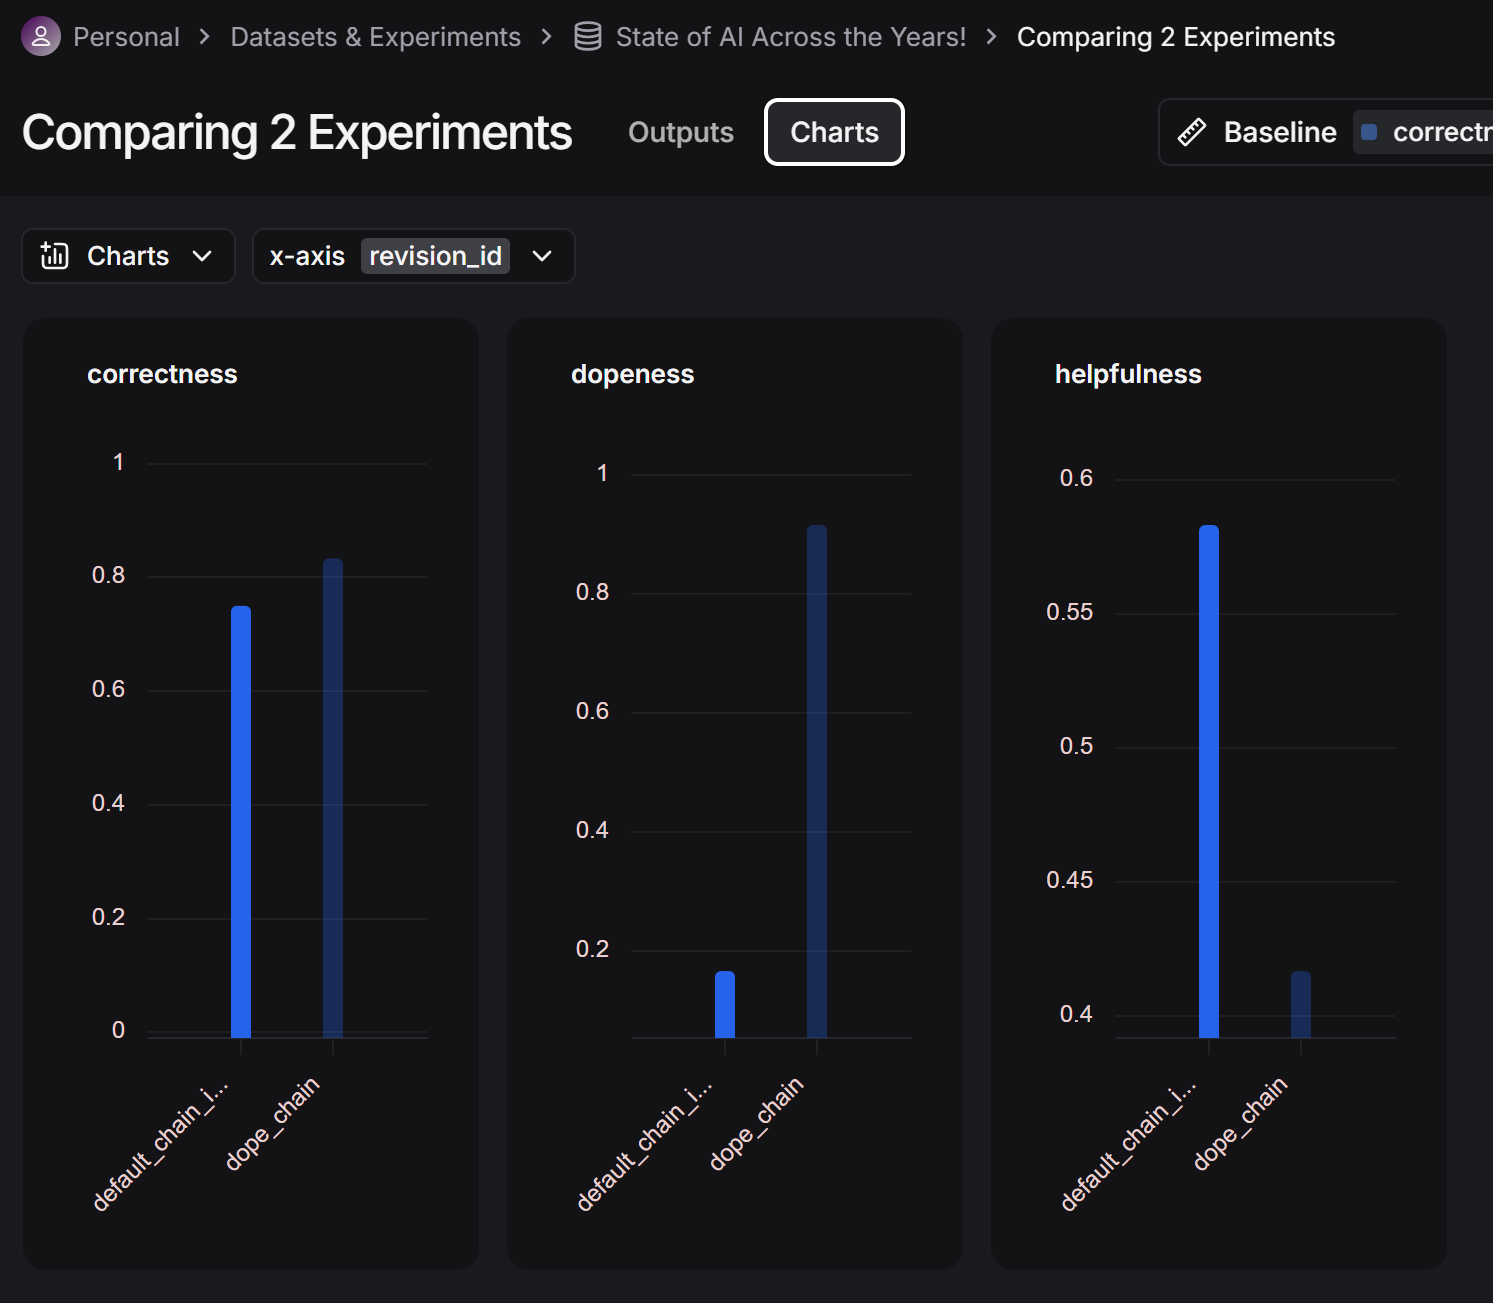

Evaluation metrics for `rag_chain`:
- Correctness: 0.75
- Dopeness: 0.17
- Helpfulness: 0.58

Evaluation metrics for `dope_rag_chain`:
- Correctness: 0.83
- Dopeness: 0.92
- Helpfulness: 0.42

#### Analysis of metric changes:

1. **Correctness Increase (0.75 → 0.83)**  
   - Primary Driver: `text-embedding-3-large` + larger chunks
   - Why:  
     • Better semantic retrieval (3-large) finds more relevant context  
     • 1000-character chunks preserve more complete information  
     • Larger model handles noise better in bigger chunks  
   - Tradeoff: Some accuracy gain offset by potential chunk noise

2. **Dopeness Surge (0.17 → 0.92)**  
   - Clear Prompt Effect: Explicit "answer in dope way" instruction  
   - Secondary Factors:  
     • Larger chunks provide more stylistic material to work with  
     • Better embeddings retrieve more opinionated/descriptive content  
   - Warning: Style focus might conflict with factual precision

3. **Helpfulness Drop (0.58 → 0.42)**  
   - Likely Culprits:  
     1. **Style-Content Tradeoff**: Dope responses prioritize flair over utility  
     2. **Chunk Size Impact**: 1000-character chunks may include irrelevant details  
     3. **Embedding Paradox**: More accurate retrieval ≠ more helpful answers  
   - Surprising Insight: While 3-large finds better context, the LLM might:  
     • Over-index on stylistic elements in larger chunks  
     • Sacrifice directness for "cool" phrasing

**Key Interaction**: The embedding model upgrade (3-small → 3-large) enabled larger chunks without catastrophic quality loss, but the stylistic prompt reshaped how retrieved context gets utilized. The system now optimizes for different success criteria.

**Practical Implications**:  
✓ Confirms embedding quality allows larger context windows  
✓ Shows prompt engineering can dramatically alter perceived quality  
✗ Reveals tension between factual helpfulness and "dope" style  